<a href="https://colab.research.google.com/github/tsiligardi/PRA3024-Analysis-of-big-data-in-physics/blob/main/ML_gym_reinforcement_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cartpole game, as per https://keon.io/deep-q-learning/
#!pip install gym

# GYM provides an environment for an agent to interact with. We'll look at the 'cartpole',
#  or the unstable, top-heavy inverted pendulum on top of a cart, which our 'agent' must learn to balance.
#
# GYM provides:
#  - a state (observation) of the system/environment
#    (in case of cartpole: cart position and velocity, angle and velocity at the tip
#  - a set of _actions_ the agent can undertake in the environment
#    (in case of cartpole: moving the cart base left or right)

# When an agent performs a certain action in the current enviroment, GYM returns
#  - a _reward_ for a certain result of performing the action in the environment
#    (in case of cartpole: +1 if it didn't die.)
#  - the new _state_ of the environment after performing said action
#    (in case of cartpole: the effect of gravity pulling on the pendulum's top, on the angle, in one time step)
#  - a 'terminal' in case the state is such that the agent cannot continue (is 'dead')
#    (in case of cartpole: if the angle exceeds > 5 degrees of tipping over, or it flies off-screen)

# It is up to us to make an agent that learns which action to take in which state, to maximise the total reward before it dies.
#  We do this by 'remembering' what the results were of certain actions on certain states in a memory (i.e. a list or deque),
#  And after every 'death' we sample ('replay') from this memory to train a neural network that decides the best actions
#   we can take on any state we've encountered so far, which maximises the total reward.

# In addition, GYM provides a nice real-time visual output of the environment and the result of actions taken.
#  In google COLAB however, we pull some strings, and only have a combined video at the end.


The code reflect the final version. For a complete descriptions of the different changes, please look at the report at the end

In [ ]:
COLAB = True

if(COLAB) :
  # install some helpers to visualize gym graphics in the colab environment
  !pip install gym==0.22
  !pip install pyvirtualdisplay
  !pip install imageio-ffmpeg
  !pip install moviepy==1.0.3
  !pip install pygame
  !apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 KB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.22.0-py3-none-any.whl size=708391 sha256=b68693a62906f709c6c208db61d57e9b89f69517f57682413ea9d8a882b0e3a9
  Stored in directory: /root/.cache/pip/wheels/c4/15/15/94c62e06887fb88768c5fa41482b80905ea71f3ede81040ffa
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 50.4 MB/s

In [ ]:
COLAB=True#repeating here, so that every time a restart the runtime, I do not have to 
#run again the installation packages
import gym
import numpy as np
from matplotlib import pyplot as plt
import random

from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
# only necessary for visualisation in colab env.
if(COLAB) :
  from IPython.display import HTML
  from IPython import display as ipythondisplay
  from pyvirtualdisplay import Display
  from gym.wrappers import Monitor
  import glob, io, os, base64
  from moviepy.editor import VideoFileClip, concatenate_videoclips

  display = Display(visible=0, size=(1400, 900))
  display.start()
  #os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

  def combine_videos() :
    mp4list = sorted( glob.glob('video/*.mp4') )
    if len(mp4list) > 0 :
      videolist = []
      for mp4 in mp4list :
        videolist.append( VideoFileClip(mp4))
      final_clip = concatenate_videoclips(videolist)
      final_clip.to_videofile("combined.mp4", fps=24, remove_temp=False)
      return 1
    else :
      return 0

  def show_video() :
      if(combine_videos()) :
        video = io.open("combined.mp4", 'r+b').read()

        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
               </video>'''.format(encoded.decode('ascii'))))
      else :
        print("Error: no videos found")     


  def wrap_env(env):
    env = Monitor(env, './video', video_callable=lambda episode_id: True, force=True)
    return env


In [ ]:
ENV_NAME = "CartPole-v1"

### STUDENT CODE HERE ###
### --> Change the parameters below to perform a better training
#This code is the final result of many explorations
#You can find a more detail description at the end
MAXRUNS = 20
#Unfortunately, at least on my laptop, colab is giving me problem when running simulation
#with lots of runs. Therefore, I had to reduce this value quite a bit to optimize the other
#parameters (more on this in the report at the end)
#Note that sometimes even 20 runs is too much (depending on how well the training is going)
# NSTEPSOLVED = 1000

GAMMA = 0.75  # 'future discount factor'
LEARNING_RATE = 0.001 # rate at which to update weights after each training step

MEMORY_SIZE = 500 # size of container to hold actions and outcomes
BATCH_SIZE = 20 # number of actions in memory to 'replay' after each death

# probability to do 'random' actions, to sample from event space
EXPLORATION_MAX = 1.0  
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995   # 0.995 --> 1% after ~35 runs
#By increasing the exploration decay, the chances of random move is higher for more turns
#The following portion of the code, allows the cartpole to do a random action every few.
#I decided to disable it, since it is very likely to make colab crush 
RANDOM_TRUE=False #Set this to false if you don't want to have this functionality
#If you want to try it with te random actions, I strongly recomend not doing more than 10/15 runs especially on colab
RANDOM_EVERY=100#number of actions after which the cartpole does a random one


In [ ]:
class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        # This will be a simple feed-forward NN, with 
        #  - input = 'observation' (aka state)
        #  - output = predicted 'quality' of each possible action
        self.model = Sequential()

        ### STUDENT CODE HERE ###
        ### --> Write the network using fully-connected (Dense) layers.
        ###  Make sure the input has the same shape as an observation/state,
        ###   and the output has the same dimensions as the number of possible actions.
        
        self.model.add(Dense(25, input_shape=(observation_space,), activation="relu"))#hidden layer 1
        #kernel_initializer initialize the distribution of the weights of the layer
        self.model.add(Dense(25, activation="relu"))#hidden layer 2
        self.model.add(Dense(self.action_space, activation="relu"))
        
        ### END STUDENT CODE ###
        
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))
        self.model.summary()
        
    def remember(self, state, action, reward, next_state, done):
        # add event to memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # return the best possible action for the current state

        # sometimes allow for a random action at the 'exploration rate', to avoid local minima
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        
        # Get predicted qualities for each possible action, and return the action (=index) with the highest quality
        q_values = self.model.predict(state) 
        return np.argmax(q_values[0])

    def experience_replay(self):
        # Learn from random subset of memory (reduces corr. between subsequent actions).
        # learning is done by comparing 'predicted quality' to the here defined quality (~reward) of the action.
        
        if len(self.memory) < BATCH_SIZE:
            # We haven't experienced enough to properly learn yet - keep exploring!
            return
        
        # Get random subset of memory
        batch = random.sample(self.memory, BATCH_SIZE) 
        
        for state, action, reward, state_next, terminal in batch:

            # We define the 'quality' of a move by taking the known, memorized reward for the action,
            #  and adding the predicted quality of the (predicted) best choice of action for the next state, to that.
            # As the model learns to give this situation a low quality, any step leading up to this state will get a 
            #  lower quality due to the predict(state_next) term. This will slowly trickle through to the step before that, etc.,
            #  slowly making our agent learn about future consequences of current actions.
          
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
                
            # - Define the quality of the non-chosen action to just be the predicted quality (i.e. diff = 0)
            # - Define the quality of the chosen action to be the newly defined quality
            q_values = self.model.predict(state)
            q_values[0][action] = q_update 
            
            # Finally, find the optimal model weights for minimal difference between 
            #  predicted quality and observed quality (+ future prediction as per above) for this action.
            # The weights are then updated * learning rate
            self.model.fit(state, q_values, verbose=0) 
            
        # reduce the 'random choices' rate over time, because you expect the model to have learned
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

In [ ]:
def cartpole() :
    if(COLAB) : env = wrap_env(gym.make(ENV_NAME)) # only for visualisation in colab
    else : env = gym.make(ENV_NAME)

    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)
       
    run=0
    runsteplog = []
    random_count=0
    #while True:
    for i in range(MAXRUNS):
        run += 1
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        
        while True :    
            step += 1
            screen = env.render() # graphical output
            # decide on an action
            ### STUDENT CODE HERE
            ### --> Redefine the action to be the output of the 'act' of your solver.
            if (RANDOM_TRUE and random_count ==RANDOM_EVERY):
              action=env.action_space.sample()
              random_count=0
            else:
              action = dqn_solver.act(state)
              if (RANDOM_TRUE):
                random_count+=1
            #action = env.action_space.sample() # (this takes a random action)
            ### END STUDENT CODE

            
            # make the action
            state_next, reward, terminal, info = env.step(action) 

            # if action made terminal: reduce reward!
            reward = reward if not terminal else -reward  

            state_next = np.reshape(state_next, [1, observation_space])

            # fill agent memory with this action's results
            dqn_solver.remember(state, action, reward, state_next, terminal) 

            # prepare for the next action in the environment
            state = state_next 
            
            if terminal :
                #state = env.reset()
                #state = np.reshape(state, [1, observation_space])
                print("Run: {0}, exploration: {1:.15f}, score: {2}".format(run,dqn_solver.exploration_rate,step))
                runsteplog += [step]

                break
            
            dqn_solver.experience_replay() # learn from batch of memories every time a new one is made
            
            #if(step > NSTEPSOLVED) :
            #    i = MAXRUNS
            #    print("Solved! (step > NSTEPSOLVED)")
            #    break


    env.close()
    


    # Show training process
    
    # plot #steps achieved
    plt.plot(runsteplog)
    plt.ylabel("# actions before terminal")
    plt.xlabel("run iteration")
    #plotting initial parameters
    plt.title("Runs: {}, \nGamma: {} \nlearning rate {} \n Exploration rate: max {}, min {}, decay:{},:".format(MAXRUNS,GAMMA,
                                                                                                                             LEARNING_RATE,EXPLORATION_MAX,EXPLORATION_MIN,EXPLORATION_DECAY), ha="center", fontsize=18,);

    success_measure = np.mean(runsteplog[-15:])
    print("Mean of last 15 runs: {0}".format(success_measure))
    return success_measure


  super().__init__(name, **kwargs)



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 33ms/step
Run: 17, exploration: 0.057432275690785, score: 63
1/1 [==============================] - 0s 45ms/step
Run: 18, exploration: 0.050414576631962, score: 27
1/1 [==============================] - 0s 23ms/step
Run: 19, exploration: 0.036947676350225, score: 63
1/1 [==============================] - 0s 22ms/step
Run: 20, exploration: 0.031630250676416, score: 32
Mean of last 15 runs: 41.0
Moviepy - Building video combined.mp4.
Moviepy - Writing video combined.mp4



Moviepy - Done !
Moviepy - video ready combined.mp4


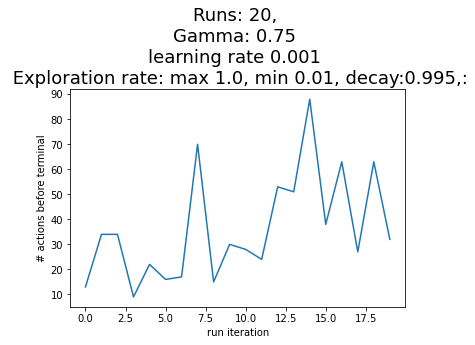

In [8]:
#Here, If I have time, ask the user if he  wanna change the parameters (maybe it's a nice personalization)
if __name__ == "__main__":
    cartpole()

if(COLAB) :
    show_video() 

<H1>Report</H1>
Here below a description of the main finidings while I was trying different combinations of the parmeters and/or of the neural network structure
<h2>A general note</h2>
Unfortunately, colab has quite a limited RAM. Therefore, especially when using large memory and batch size, it is almost impossible to do more than 20 runs for the training, which is a very small number. 
Therefore, the results may better or worse due to chance. To reduce this effect, Whenever I changed something, I tried to run it multiple times and, therefore, all the considerations higlight the general trends observed.
<H2>Initial set of parametrs and neural network </H2>
I started with the following set of parameters 

```
MAXRUNS = 30
#NSTEPSOLVED = 1000

GAMMA = 0.5  # 'future discount factor'
LEARNING_RATE = 0.000001 # rate at which to update weights after each training step

MEMORY_SIZE = 100 # size of container to hold actions and outcomes
BATCH_SIZE = 5 # number of actions in memory to 'replay' after each death

# probability to do 'random' actions, to sample from event space
EXPLORATION_MAX = 1.0  
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995   # 0.995 --> 1% after ~35 runs
```
and with a nerual netwrok formed by just one hidden layer with 30 nodes with RELU as activator.



```
self.model.add(Dense(30, input_shape=(observation_space,),activation="relu"))#hidden layer 1
self.model.add(Dense(self.action_space, activation="relu"))
```
When doing so, I got the following output:<br>

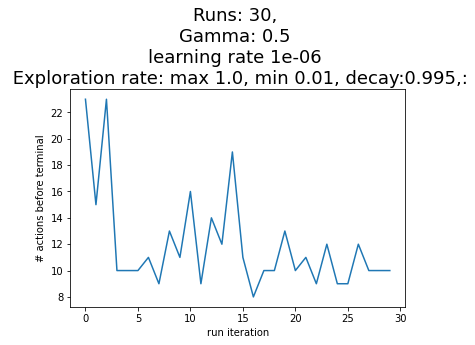
<br>Then, I tried to vary both the value of the parameters and the structure of the neural network. 
 
<h2>Increasing the explorativity </h2>
Initially, I tried to increase the explorativity. This increase the chances of random moves at the beginning, as we can see in the graph below <br>




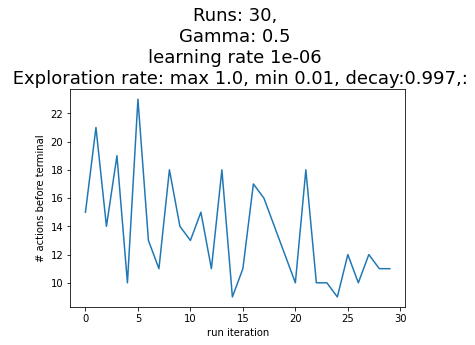

<br>This allows better results in the first runs. However especially in Colabs, where the memory capacity is limited and, therefore, it is not possible to do a very high number of runs (more on this in the coming sections), it can easily "back fire" you, since it keeps higher chances of random move when the model gets better.

<h2> Increasing the complexity of the nerual network </h2>
Next, I increased the complexity of the Neural network, by adding an extra hidden layer

```
self.model.add(Dense(50, input_shape=(observation_space,), activation="relu"))#hidden layer 1
self.model.add(Dense(30, activation="relu"))#hidden layer 2
self.model.add(Dense(self.action_space, activation="relu"))
```
This increases the complexity of the model, which may results in issues of overtraining. The results are displayed below:


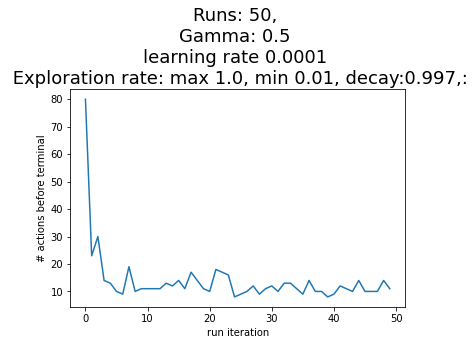

As we can see, this worsen the performance. I tried to reduce the explorativity, but the results did not change that much. I also increased the learning rate, but again there was no signficant improvement. The issue here is probabily a sort of overtraining combined with a small memory size. Since there are no many actions stored in the memory, it keep using the ones labeled as "good" for the previous situation, but that are not functional for the new ones. 

<h2>Increasing memory size and batches</h2>
Based on the previous configuration, I increased the memory size and the number of batches. At this point, set of parameters looked like: 





```
MAXRUNS = 20 #due to the limited capacity of cola, I had to reduce this value
# NSTEPSOLVED = 1000

GAMMA = 0.75  # 'future discount factor'
LEARNING_RATE = 0.001 # rate at which to update weights after each training step

MEMORY_SIZE = 500 # size of container to hold actions and outcomes
BATCH_SIZE = 20 # number of actions in memory to 'replay' after each death

# probability to do 'random' actions, to sample from event space
EXPLORATION_MAX = 1.0  
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995   # 0.995 --> 1% after ~35 runs
#By increasing the exploration decay, the chances of random move is higher for more turns
```
Unfortunately, I was not able to do more then 20 runs, due to the limited RAM capacity of google Colab. For the same reason, I also reduced a bit the complexity of the neural network (I reduced the number of nodes). 
The result is shown below<br>:
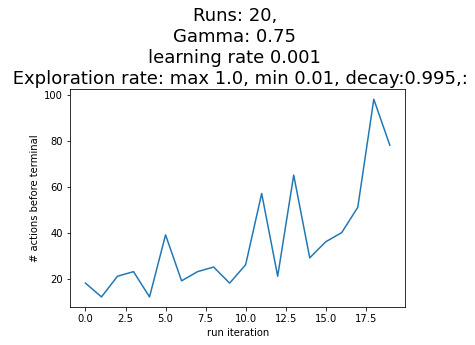
<br>Although it is only for a limited amount of runs, it looks very encouranging. In addition, the output seems in line to the one at: https://github.com/gsurma/cartpole (although this one uses a higher memory size, it has more runs, and some slightly different initial parameters).

<h2>Add random moves</h2>
Starting from the conditions described above, I wanted to study how random moves influence the learning procedure. I therefore modified the code to make the cartpole duing a random action every few (the comments in the code illustrate how this is done). Here, I set a random action every 100. Unfornutately, due to the ram limitation of colab, I was only able to make 12 runs.
<br>As the graph shows, adding the random actions seems to improve the performance of the cartpole, at least for a short amount of runs. This is because it increases the chances of avoiding local minima. However, as already mentioned for the exploration rate, it may become a disatvange as the cartpole get more trained.



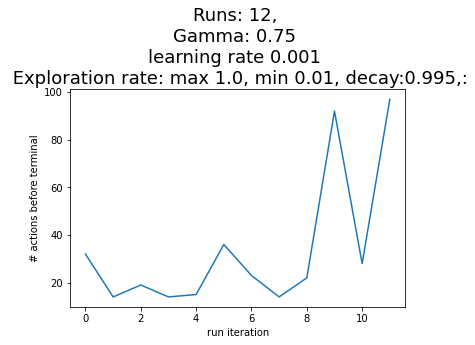

<h2>Changing activators</h2>
Another possibility is to change the activators. I decided to try some different combinations. To have the possibility of doing more runs, I disabled the option for the random actions for this test.


```
        self.model.add(Dense(25, input_shape=(observation_space,), activation="sigmoid"))#hidden layer 1
        self.model.add(Dense(25, activation="relu"))#hidden layer 2
        self.model.add(Dense(self.action_space, activation="softmax"))

```
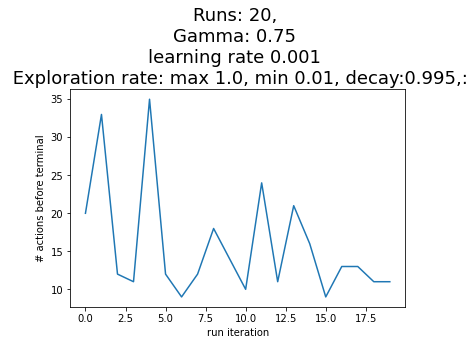<br>
I alslo tried to use the following combination: 



```
self.model.add(Dense(25, input_shape=(observation_space,), activation="relu"))#hidden layer 1
        self.model.add(Dense(25, activation="relu"))#hidden layer 2
        self.model.add(Dense(self.action_space, activation="linear"))
        
```
whith results: <br>
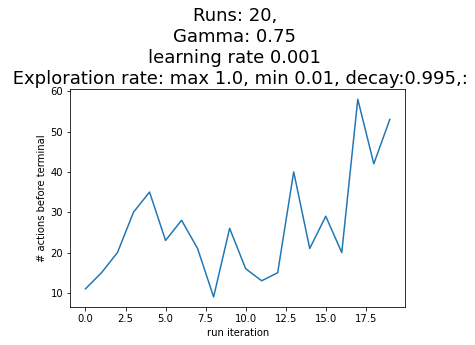
<br> Comparing these results with the one  using three relu activators, this last one seems to be the best option.


<h2>Wheights initialization</h2>
Another possibilities it to initialize the wheights disrtibution for the different layers. Keras library offers various possibilites. In particular, I tried to apply the following initializers to the first layer:
<ol>
<li>random normal distributed initializers (which is one of the most common) that generates the wheight according to a normal distribution:


```
 self.model.add(Dense(25, input_shape=(observation_space,), activation="relu", kernel_initializer='random_normal')
```
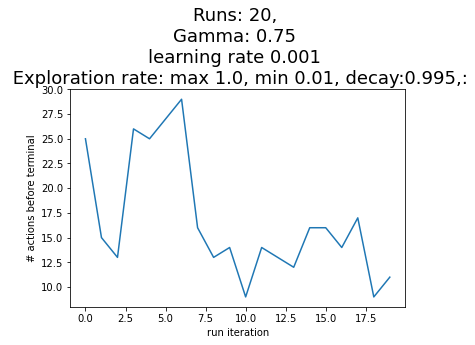
</li>
<li>Using the Xavier initializers, which is also very commonly used in machine learning


```
 self.model.add(Dense(25, input_shape=(observation_space,), activation="relu", kernel_initializer='glorot_normal'))
```
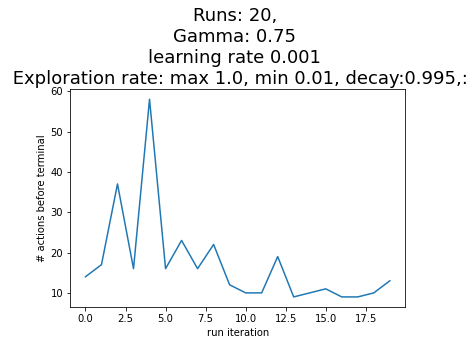 
<br> Based on these results, a completely random initialization seems the best option.

</li>
</ol>
